# Lab 4: Data Imputation using an Autoencoder


In this lab, you will build and train an autoencoder to impute (or "fill in") missing data.

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features.

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

**Instead, we will perform the task of imputing (or "filling in") missing values in the dataset.** For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.
https://colab.research.google.com/drive/1BRtWcQDbYdCbFgWwiBwtj_HQdrx18yLu?usp=sharing


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link:https://colab.research.google.com/drive/1BRtWcQDbYdCbFgWwiBwtj_HQdrx18yLu?usp=sharing

In [ ]:
import csv
import numpy as np
import random
import torch
import torch.utils.data

## Part 0

We will be using a package called `pandas` for this assignment.

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here:
https://pandas.pydata.org/pandas-docs/stable/install.html

In [ ]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [ ]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

/tmp/ipython-input-3-1831985018.py:3: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv(


In [ ]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset.

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`.

Like numpy arrays and torch tensors,
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [ ]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


Alternatively, we can slice based on column names,
for example `df["race"]`, `df["hr"]`, or even index multiple columns
like below.

In [ ]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


Numpy works nicely with pandas, like below:

In [ ]:
np.sum(subdf["caploss"])

np.int64(2842700)

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1`

would increment everyone's age by 1.

In [ ]:
# columns
cont_cols = ["age", "yredu", "capgain", "caploss", "workhr"]

# report min, max, and average for each col
for col in cont_cols:
    col_min = df[col].min()
    col_max = df[col].max()
    col_mean = df[col].mean()
    print(f"{col}: min={col_min}, max={col_max}, mean={col_mean:.2f}")

# min-max normalization
for col in cont_cols:
    col_min = df[col].min()
    col_max = df[col].max()
    df[col] = (df[col] - col_min) / (col_max - col_min)


age: min=17, max=90, mean=38.58
yredu: min=1, max=16, mean=10.08
capgain: min=0, max=99999, mean=1077.65
caploss: min=0, max=4356, mean=87.30
workhr: min=1, max=99, mean=40.44


### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [ ]:
# # hint: you can do something like this in pandas
# sum(df["sex"] == " Male")

total = len(df)

num_males = sum(df["sex"] == " Male")
num_females = sum(df["sex"] == " Female")

# percentages
perc_males = (num_males / total) * 100
perc_females = (num_females / total) * 100

print(f"Percentage of males: {perc_males:.2f}%")
print(f"Percentage of females: {perc_females:.2f}%")


Percentage of males: 66.92%
Percentage of females: 33.08%


### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to **using a subset of the features (to simplify our autoencoder)**
2. We will **remove any records (rows)** already **containing missing values**, and **store them in a second dataframe**. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [ ]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [ ]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]

In [ ]:
# num of records wuth missing values
num_missing = len(df_with_missing)
num_total = len(df_with_missing) + len(df_not_missing)

# percentage of records removed
percent_missing = (num_missing / num_total) * 100

print(f"Number of records with missing values: {num_missing}")
print(f"Percentage of records removed: {percent_missing:.2f}%")

Number of records with missing values: 1843
Percentage of records removed: 5.66%


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [ ]:
work_categories = set(df_not_missing["work"])
print(work_categories)

{' Federal-gov', ' Private', ' Self-emp-not-inc', ' State-gov', ' Without-pay', ' Self-emp-inc', ' Local-gov'}


We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`.

In [ ]:
data = pd.get_dummies(df_not_missing)

In [ ]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,...,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.02174,0.0,0.397959,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
1,0.452055,0.800000,0.00000,0.0,0.122449,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,True
2,0.287671,0.533333,0.00000,0.0,0.397959,False,False,True,False,False,...,False,False,False,True,False,False,False,False,False,True


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [ ]:
col_count = len(data.columns)
print(f"Number of columns: {col_count}")

Number of columns: 57


The dataframe data has 57 columns.

This includes the 5 continuous features and 52 one-hot encoded columns that were created from the 8 categorical features.

Each categorical feature was expanded into several binary columns based on the number of unique values it had.


### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

**Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding**.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not
actually be "one-hot" -- the input may instead
contain real-valued predictions from our neural network.

In [ ]:
datanp = data.values.astype(np.float32)

In [ ]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.

    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.

    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`

    Examples:

    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    # <----- TODO: WRITE YOUR CODE HERE ----->
    # You may find the variables `cat_index` and `cat_values`
    # (created above) useful.

    # index of maximum value
    idx = np.argmax(onehot)

    # return the corresponding categorical value label
    return cat_values[feature][idx]



In [ ]:
### Test function (not required by the lab)
print(get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work"))


State-gov


In [ ]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [ ]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)

# todo

# Shuffle indices
num_records = len(datanp)
indices = np.random.permutation(num_records)

# Split the dataset
train_size = int(0.7 * num_records)
val_size = int(0.15 * num_records)
test_size = num_records - train_size - val_size

train_data = datanp[indices[:train_size]]
val_data = datanp[indices[train_size:train_size + val_size]]
test_data = datanp[indices[train_size + val_size:]]

# Report sizes
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")


Training set size: 21502
Validation set size: 4607
Test set size: 4609


## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

**The input to this autoencoder will be the features of the `data`**, with
one categorical feature recorded as "missing". **The output of the autoencoder
should be the reconstruction of the same features**, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information
about ~11 features.

In [ ]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(57, 32), # TODO -- FILL OUT THE CODE HERE!
            nn.ReLU(),
            nn.Linear(32, 11),  # embed to ~11 features
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            # TODO -- FILL OUT THE CODE HERE!
            nn.Linear(11, 32),  # Expand from 11 → 32
            nn.ReLU(),
            nn.Linear(32, 57),  # Expand from 32 → 57
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

We use a sigmoid activation in the last step of the decoder because the output values of the autoencoder need to be in the range [0, 1], matching the normalized input data in the `data` dataframe.

Since all continuous features were scaled using min-max normalization, and categorical features are one-hot encoded (values 0 or 1), the network must produce outputs in this same range.

## Part 3. Training [18]

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will **hide one of the categorical features** using the `zero_out_random_features` function
- We will **pass the data with one missing feature through the autoencoder**, and obtain a **reconstruction**
- We will **check how close the reconstruction is** compared to the original data -- **including the value of the missing feature**

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [ ]:
import matplotlib.pyplot as plt

def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

def train(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for data in train_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for data in valid_loader:
                datam = zero_out_random_feature(data.clone())
                recon = model(datam)
                loss = criterion(recon, data)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(valid_loader)
        val_losses.append(avg_val_loss)

        # Accuracy tracking
        train_acc = get_accuracy(model, train_loader)
        val_acc = get_accuracy(model, valid_loader)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1:2d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Train Acc: {train_acc:.3f} | Val Acc: {val_acc:.3f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

def plot_loss(train_losses, val_losses, title="Loss Curve"):
    plt.plot(train_losses, label="Train")
    plt.plot(val_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.show()

def plot_accuracy(train_accuracies, val_accuracies, title="Accuracy Curve"):
    plt.plot(train_accuracies, label="Train")
    plt.plot(val_accuracies, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.legend()


### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few
iterations as part of your training curve.

In [ ]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature,
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the
    record. The returned "accuracy" measure is the percentage of times
    that our model is successful.

    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

Epoch  1 | Train Loss: 0.2363 | Val Loss: 0.2327 | Train Acc: 0.278 | Val Acc: 0.279
Epoch  2 | Train Loss: 0.2285 | Val Loss: 0.2237 | Train Acc: 0.278 | Val Acc: 0.279
Epoch  3 | Train Loss: 0.2170 | Val Loss: 0.2087 | Train Acc: 0.278 | Val Acc: 0.279
Epoch  4 | Train Loss: 0.1943 | Val Loss: 0.1761 | Train Acc: 0.330 | Val Acc: 0.331
Epoch  5 | Train Loss: 0.1546 | Val Loss: 0.1313 | Train Acc: 0.331 | Val Acc: 0.332
Epoch  6 | Train Loss: 0.1108 | Val Loss: 0.0941 | Train Acc: 0.440 | Val Acc: 0.439
Epoch  7 | Train Loss: 0.0852 | Val Loss: 0.0791 | Train Acc: 0.458 | Val Acc: 0.457
Epoch  8 | Train Loss: 0.0763 | Val Loss: 0.0743 | Train Acc: 0.458 | Val Acc: 0.457
Epoch  9 | Train Loss: 0.0734 | Val Loss: 0.0727 | Train Acc: 0.458 | Val Acc: 0.457
Epoch 10 | Train Loss: 0.0722 | Val Loss: 0.0719 | Train Acc: 0.458 | Val Acc: 0.457
Epoch 11 | Train Loss: 0.0717 | Val Loss: 0.0715 | Train Acc: 0.458 | Val Acc: 0.457
Epoch 12 | Train Loss: 0.0713 | Val Loss: 0.0711 | Train Acc: 0.4

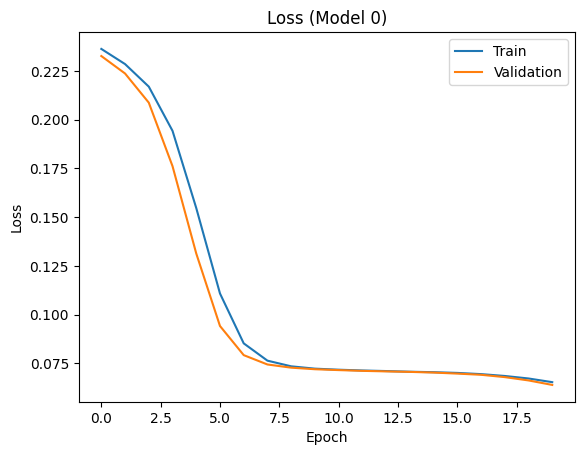

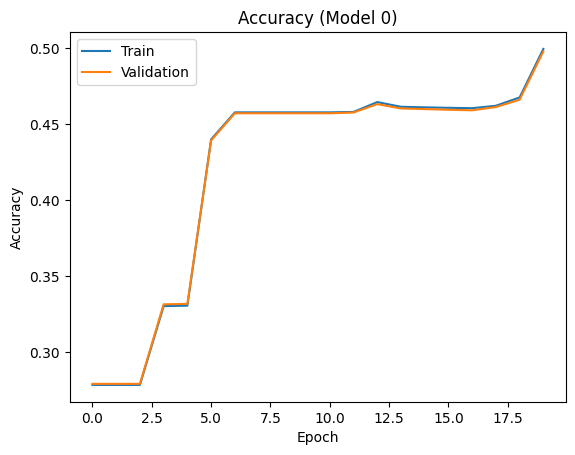

In [ ]:
model = AutoEncoder()

train_loader = torch.utils.data.DataLoader(train_data, batch_size=256, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=256, shuffle=False)
train_losses, val_losses, train_acc, val_acc = train(model, train_loader, valid_loader, num_epochs=20, learning_rate=1e-4)

plot_loss(train_losses, val_losses, title="Loss (Model 0)")
plot_accuracy(train_acc, val_acc, title="Accuracy (Model 0)")

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you
chose the next set of hyperparameters to try.

####  Model 1: Deeper Network (3-layer encoder/decoder)

**Hyperparameters**:
- Architecture: 57 → 48 → 24 → 11 → 24 → 48 → 57

**Thought process**:
A deeper network could capture more non-linear structure.

**Effect**:
- Validation accuracy increased from 0.498 (model 0) to 0.609

In [ ]:
class AutoEncoder1(nn.Module):  # Deeper model
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(57, 48),
            nn.ReLU(),
            nn.Linear(48, 24),
            nn.ReLU(),
            nn.Linear(24, 11),  # final compressed embedding
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(11, 24),
            nn.ReLU(),
            nn.Linear(24, 48),
            nn.ReLU(),
            nn.Linear(48, 57),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))


In [ ]:
model = AutoEncoder1()
train_loader = torch.utils.data.DataLoader(train_data, batch_size=256, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=256, shuffle=False)

train_losses, val_losses, train_acc, val_acc = train(model, train_loader, valid_loader, num_epochs=20, learning_rate=1e-3)

Epoch  1 | Train Loss: 0.1462 | Val Loss: 0.0730 | Train Acc: 0.460 | Val Acc: 0.459
Epoch  2 | Train Loss: 0.0710 | Val Loss: 0.0701 | Train Acc: 0.460 | Val Acc: 0.459
Epoch  3 | Train Loss: 0.0688 | Val Loss: 0.0662 | Train Acc: 0.453 | Val Acc: 0.452
Epoch  4 | Train Loss: 0.0597 | Val Loss: 0.0554 | Train Acc: 0.517 | Val Acc: 0.519
Epoch  5 | Train Loss: 0.0536 | Val Loss: 0.0527 | Train Acc: 0.565 | Val Acc: 0.566
Epoch  6 | Train Loss: 0.0519 | Val Loss: 0.0511 | Train Acc: 0.585 | Val Acc: 0.584
Epoch  7 | Train Loss: 0.0499 | Val Loss: 0.0489 | Train Acc: 0.583 | Val Acc: 0.582
Epoch  8 | Train Loss: 0.0473 | Val Loss: 0.0459 | Train Acc: 0.590 | Val Acc: 0.589
Epoch  9 | Train Loss: 0.0439 | Val Loss: 0.0426 | Train Acc: 0.590 | Val Acc: 0.590
Epoch 10 | Train Loss: 0.0417 | Val Loss: 0.0416 | Train Acc: 0.596 | Val Acc: 0.594
Epoch 11 | Train Loss: 0.0402 | Val Loss: 0.0408 | Train Acc: 0.597 | Val Acc: 0.596
Epoch 12 | Train Loss: 0.0391 | Val Loss: 0.0382 | Train Acc: 0.6

#### Model 2: higher learning rate

**Hyperparameters**:

Same as Model 1, but learning_rate = 5e-4


**Thought process**:
A higher learning rate helped early training but introduced noise in optimization.

**Effect**:

- Model converged faster in early epochs
- Slight instability in validation loss around epoch 13+
- Accuracy didn’t improve much (highest val acc is 0.610)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=128, shuffle=False)
model = AutoEncoder1()

train_losses, val_losses, train_acc, val_acc = train(model, train_loader, valid_loader, num_epochs=20, learning_rate=5e-4)

Epoch  1 | Train Loss: 0.1365 | Val Loss: 0.0712 | Train Acc: 0.460 | Val Acc: 0.459
Epoch  2 | Train Loss: 0.0703 | Val Loss: 0.0692 | Train Acc: 0.459 | Val Acc: 0.458
Epoch  3 | Train Loss: 0.0644 | Val Loss: 0.0564 | Train Acc: 0.529 | Val Acc: 0.529
Epoch  4 | Train Loss: 0.0546 | Val Loss: 0.0536 | Train Acc: 0.562 | Val Acc: 0.562
Epoch  5 | Train Loss: 0.0529 | Val Loss: 0.0521 | Train Acc: 0.569 | Val Acc: 0.569
Epoch  6 | Train Loss: 0.0512 | Val Loss: 0.0499 | Train Acc: 0.582 | Val Acc: 0.581
Epoch  7 | Train Loss: 0.0492 | Val Loss: 0.0483 | Train Acc: 0.580 | Val Acc: 0.580
Epoch  8 | Train Loss: 0.0470 | Val Loss: 0.0452 | Train Acc: 0.581 | Val Acc: 0.582
Epoch  9 | Train Loss: 0.0440 | Val Loss: 0.0425 | Train Acc: 0.585 | Val Acc: 0.585
Epoch 10 | Train Loss: 0.0421 | Val Loss: 0.0409 | Train Acc: 0.594 | Val Acc: 0.593
Epoch 11 | Train Loss: 0.0393 | Val Loss: 0.0372 | Train Acc: 0.608 | Val Acc: 0.607
Epoch 12 | Train Loss: 0.0370 | Val Loss: 0.0357 | Train Acc: 0.6

#### Model 3: Smaller Batch Size

**Hyperparameters**:

Same as Model 1, but batch_size = 64


**Thought process**:
Smaller batches added noise, helping generalization slightly, but at a higher compute cost.

**Effect**:

- Losses was noisier

- Validation accuracy slightly improved and peaked at 0.615

- Slower training time


In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=False)
model = AutoEncoder1()

train_losses, val_losses, train_acc, val_acc = train(model, train_loader, valid_loader, num_epochs=20, learning_rate=1e-3)

Epoch  1 | Train Loss: 0.0878 | Val Loss: 0.0562 | Train Acc: 0.532 | Val Acc: 0.534
Epoch  2 | Train Loss: 0.0491 | Val Loss: 0.0435 | Train Acc: 0.581 | Val Acc: 0.583
Epoch  3 | Train Loss: 0.0396 | Val Loss: 0.0356 | Train Acc: 0.599 | Val Acc: 0.600
Epoch  4 | Train Loss: 0.0341 | Val Loss: 0.0316 | Train Acc: 0.615 | Val Acc: 0.616
Epoch  5 | Train Loss: 0.0306 | Val Loss: 0.0286 | Train Acc: 0.616 | Val Acc: 0.613
Epoch  6 | Train Loss: 0.0272 | Val Loss: 0.0267 | Train Acc: 0.611 | Val Acc: 0.607
Epoch  7 | Train Loss: 0.0258 | Val Loss: 0.0253 | Train Acc: 0.608 | Val Acc: 0.608
Epoch  8 | Train Loss: 0.0248 | Val Loss: 0.0247 | Train Acc: 0.613 | Val Acc: 0.610
Epoch  9 | Train Loss: 0.0239 | Val Loss: 0.0243 | Train Acc: 0.612 | Val Acc: 0.607
Epoch 10 | Train Loss: 0.0230 | Val Loss: 0.0235 | Train Acc: 0.613 | Val Acc: 0.609
Epoch 11 | Train Loss: 0.0224 | Val Loss: 0.0227 | Train Acc: 0.607 | Val Acc: 0.604
Epoch 12 | Train Loss: 0.0218 | Val Loss: 0.0219 | Train Acc: 0.6

#### Model 4: Add Dropout Regularization

**Hyperparameters**:

Architecture: same as Model 3, but add Dropout(0.2) after each hidden layer


**Thought Process**:
Dropout helps prevent co-adaptation of neurons and forces the network to learn more robust features. Since deeper networks tend to overfit, adding dropout reduced this risk and led to stronger generalization.


**Effect**:
- Validation accuracy peaked at 0.622, improved from 0.615 (Model 3)



In [ ]:
class AutoEncoder2(nn.Module):  # Deeper model
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(57, 48),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(48, 24),
            nn.ReLU(),
            nn.Linear(24, 11),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(11, 24),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(24, 48),
            nn.ReLU(),
            nn.Linear(48, 57),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))


In [ ]:
model = AutoEncoder2()
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=False)

train_losses, val_losses, train_acc, val_acc = train(model, train_loader, valid_loader, num_epochs=20, learning_rate=1e-3)


Epoch  1 | Train Loss: 0.0871 | Val Loss: 0.0566 | Train Acc: 0.539 | Val Acc: 0.542
Epoch  2 | Train Loss: 0.0531 | Val Loss: 0.0473 | Train Acc: 0.586 | Val Acc: 0.585
Epoch  3 | Train Loss: 0.0463 | Val Loss: 0.0415 | Train Acc: 0.606 | Val Acc: 0.602
Epoch  4 | Train Loss: 0.0429 | Val Loss: 0.0386 | Train Acc: 0.620 | Val Acc: 0.614
Epoch  5 | Train Loss: 0.0409 | Val Loss: 0.0370 | Train Acc: 0.622 | Val Acc: 0.615
Epoch  6 | Train Loss: 0.0389 | Val Loss: 0.0351 | Train Acc: 0.609 | Val Acc: 0.603
Epoch  7 | Train Loss: 0.0374 | Val Loss: 0.0335 | Train Acc: 0.618 | Val Acc: 0.614
Epoch  8 | Train Loss: 0.0366 | Val Loss: 0.0326 | Train Acc: 0.622 | Val Acc: 0.615
Epoch  9 | Train Loss: 0.0359 | Val Loss: 0.0323 | Train Acc: 0.625 | Val Acc: 0.618
Epoch 10 | Train Loss: 0.0354 | Val Loss: 0.0314 | Train Acc: 0.616 | Val Acc: 0.613
Epoch 11 | Train Loss: 0.0349 | Val Loss: 0.0311 | Train Acc: 0.624 | Val Acc: 0.619
Epoch 12 | Train Loss: 0.0346 | Val Loss: 0.0306 | Train Acc: 0.6

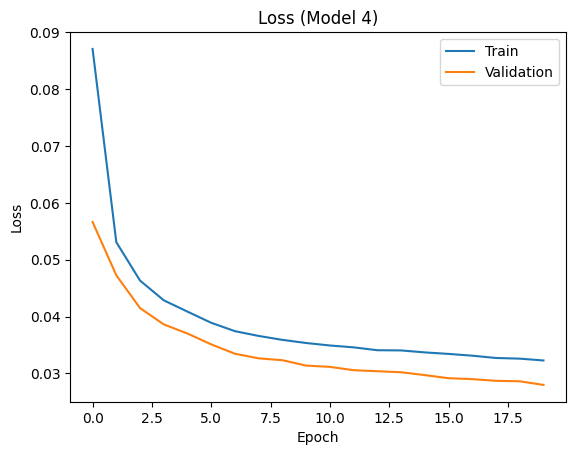

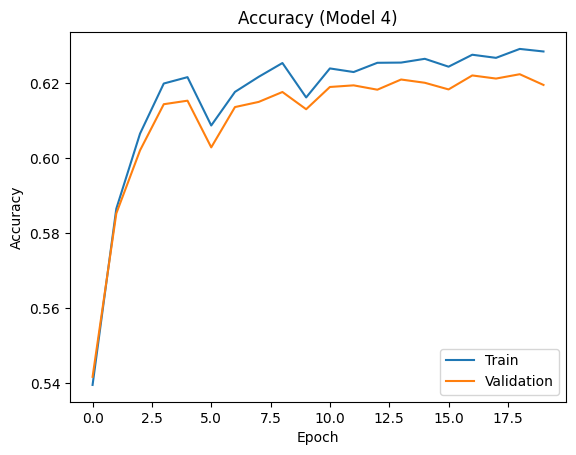

In [ ]:
plot_loss(train_losses, val_losses, title="Loss (Model 4)")
plot_accuracy(train_acc, val_acc, title="Accuracy (Model 4)")

## Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

In [ ]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)
test_accuracy = get_accuracy(model, test_loader)
print(f"Test Accuracy: {test_accuracy:.3f}")


Test Accuracy: 0.625


### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set.

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


In [ ]:
def get_baseline_accuracy(train_data, test_data):
    total = 0
    correct = 0

    for col in catcols:
        # Get column indices
        start_idx = cat_index[col]
        stop_idx = start_idx + len(cat_values[col])

        # Compute most common one-hot vector in train set
        train_mode_idx = train_data[:, start_idx:stop_idx].sum(axis=0).argmax()
        most_common_vector = np.zeros(stop_idx - start_idx)
        most_common_vector[train_mode_idx] = 1

        # Compare against test data
        for record in test_data:
            true_vector = record[start_idx:stop_idx]
            if np.array_equal(true_vector, most_common_vector):
                correct += 1
            total += 1

    return correct / total


In [ ]:
baseline_acc = get_baseline_accuracy(train_data, test_data)
print(f"Baseline Test Accuracy: {baseline_acc:.3f}")

Baseline Test Accuracy: 0.457


### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

Baseline Test Accuracy: 0.457

Our model’s test accuracy is 0.625, which outperforms the baseline by a substantial margin, showing the autoencoder is learning meaningful feature relationships instead of memorizing the most common values.

### Part (d) [1 pt]

Look at the first item in your test data.
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

In [ ]:
print(test_data[0])

[0.         0.4        0.         0.         0.15306123 0.
 0.         1.         0.         0.         0.         0.
 0.         0.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         1.         0.
 0.         1.         0.        ]


In [ ]:
# readable format:
print(df_not_missing.iloc[indices[train_size + val_size]])

age                           0.0
yredu                         0.4
capgain                       0.0
caploss                       0.0
workhr                   0.153061
work                      Private
marriage            Never-married
occupation       Transport-moving
edu                          11th
relationship            Own-child
sex                        Female
Name: 23170, dtype: object


It is reasonable to for a human to be able to guess this person's education level based on other features.

1. Age is 0.0 after normalization, so its a really young age
2. yredu is also low, so only received a few years of educationso far
3. Working hours is also low, suggesting the person hasn't worked a lot. Might be a high schooler
4. Occupation is Transport-moving, which doesn't require a high education background
5. <=Marital status is never-married, so this person is likely still a student

In conclusion, this person might be a 14-18 year-old student.

### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


In [ ]:
# Get the test record and zero out 'edu'
record = test_data[0].copy()
record_with_missing = zero_out_feature(record.reshape(1, -1).copy(), "edu")

# Pass through model4 and get prediction
reconstructed = model(torch.tensor(record_with_missing, dtype=torch.float32)).detach().numpy()[0]

# Extract only the 'edu' portion of the output
edu_onehot_pred = get_onehot(reconstructed, "edu")

# Decode one-hot vector to education label
predicted_edu = get_categorical_value(edu_onehot_pred, "edu")
print("Model4's prediction for education:", predicted_edu)


Model4's prediction for education: HS-grad


The model predicted this person is a HS-grad

### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

In [ ]:
most_common_edu = df_not_missing["edu"].iloc[indices[:train_size]].mode()[0]
print("Baseline model prediction for education:", most_common_edu)

Baseline model prediction for education:  HS-grad


The baseline model always predict the most common value from the training set, which is HS-grad.